# Description
Estimate the first-of-season date using a rolling window and mean arrival date using the logistic growth function.

In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t
import scipy.optimize as optim
import random

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [3]:
os.getcwd()

'/Users/alvastrand/Documents/OU/Research/notebooks/calculate_arrival_date'

In [4]:
path = '/Users/alvastrand/'
os.chdir(path)

In [5]:
os.getcwd()

'/Users/alvastrand'

In [6]:
grid_cell = 136
year = 2014

In [7]:
filename = 'ebd_US_barswa_201001_202001_zerofilled_block_' + str(grid_cell) + '_year_' + str(year) + \
'_prop_relJan-2020_v2.csv'
# filename = 'ebd_US_barswa_201001_202001_zerofilled_block_' + str(grid_cell) + '_year_' + str(year) + \
# '_prop_relJan-2020.csv'
df_block_year = pd.read_csv(filename)

In [8]:
df_block_year['observation_date_dt'] = pd.to_datetime(df_block_year['observation_date'])

In [9]:
df_block_year.shape
# (102, 7)

(211, 7)

In [10]:
df_block_year.head(2)

,grid_cell,observation_date,nb_checklists,nb_checklists_species,prop,year,observation_date_dt
0,136,2014-01-01,501,0.0,0.0,2014,2014-01-01
1,136,2014-01-02,162,0.0,0.0,2014,2014-01-02


In [11]:
print(min(df_block_year['observation_date_dt']))
print(max(df_block_year['observation_date_dt']))

2014-01-01 00:00:00
2014-07-30 00:00:00


In [12]:
# df_block_year = df_block_year.head(2)

In [13]:
if filename == 'ebd_US_barswa_201001_202001_zerofilled_block_' + str(grid_cell) + '_year_' + str(year) + \
'_prop_relJan-2020_v2.csv':
    
    start_month = 1
    start_day = 1

    end_month = 7
    end_day = 30
    
elif filename == 'ebd_US_barswa_201001_202001_zerofilled_block_' + str(grid_cell) + '_year_' + str(year) + \
'_prop_relJan-2020.csv':
    
    start_month = 3
    start_day = 20

    end_month = 6
    end_day = 29

start_date = datetime(year, start_month, start_day)
end_date = datetime(year, end_month, end_day)

In [14]:
date_range = pd.date_range(start_date, end_date)

In [15]:
date_range_str = date_range.strftime('%Y-%m-%d')

In [16]:
df_date_range = pd.DataFrame({'grid_cell': grid_cell, 'year': year, 'observation_date': date_range_str, 
                              'observation_date_dt': date_range})

In [17]:
df_date_range.shape
# (102, 4)

(211, 4)

In [18]:
df_date_range.head(2)

,grid_cell,year,observation_date,observation_date_dt
0,136,2014,2014-01-01,2014-01-01
1,136,2014,2014-01-02,2014-01-02


In [19]:
df_block_year = df_date_range.merge(df_block_year, how='left', on=['grid_cell', 'year', 'observation_date', 
                                                                   'observation_date_dt'])

In [20]:
df_block_year.shape
# (102, 7)

(211, 7)

In [21]:
df_block_year.head(2)

,grid_cell,year,observation_date,observation_date_dt,nb_checklists,nb_checklists_species,prop
0,136,2014,2014-01-01,2014-01-01,501,0.0,0.0
1,136,2014,2014-01-02,2014-01-02,162,0.0,0.0


In [22]:
# Perform arcsine transformation on the proportions
df_block_year['prop_arcsine'] = df_block_year['prop'].apply(lambda x: np.arcsin(math.sqrt(x)))

In [23]:
df_block_year.shape
# (102, 8)

(211, 8)

In [24]:
df_block_year.head(2)

,grid_cell,year,observation_date,observation_date_dt,nb_checklists,nb_checklists_species,prop,prop_arcsine
0,136,2014,2014-01-01,2014-01-01,501,0.0,0.0,0.0
1,136,2014,2014-01-02,2014-01-02,162,0.0,0.0,0.0


In [25]:
df_block_year['prop_arcsine'].isnull().values.any()

False

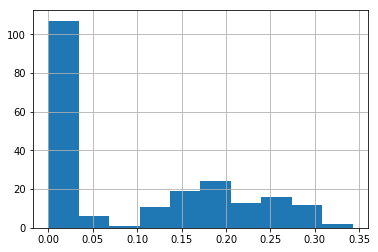

In [26]:
df_block_year['prop'].hist()
plt.show()

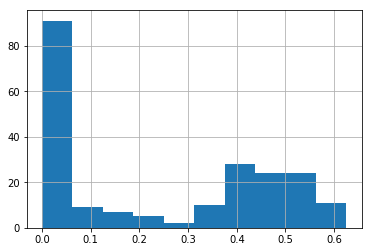

In [27]:
df_block_year['prop_arcsine'].hist()
plt.show()

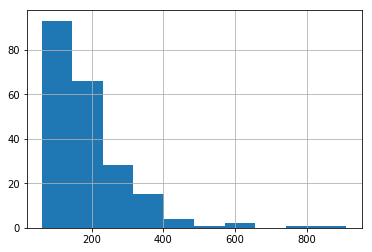

In [28]:
df_block_year['nb_checklists'].hist()
plt.show()

In [29]:
# Rolling window approach

In [30]:
window_size = 7
# ?
confidence = 0.95

means = []
sems = []
hs = []
lower_bounds = []
upper_bounds = []

start_index = 0
end_index = window_size

print(len(df_block_year) - window_size + 1)

for i in range(len(df_block_year) - window_size + 1):
    
#     if start_index == 11:
#         break

    print('---')
    
    print(start_index)
    print(end_index)
    
    df_sample = df_block_year.iloc[range(start_index, end_index)]
    df_sample = df_sample.dropna()
    
    weights = df_sample['nb_checklists']

    dof = len(df_sample) - 1
    # dof = 0
#     print(dof)
    # ?

    weighted_stats = DescrStatsW(df_sample['prop_arcsine'], weights=weights, ddof=dof)

    mean = weighted_stats.mean
    means.append(mean)
#     print(mean)

    sem = weighted_stats.std_mean
    sems.append(sem)
#     print(sem)

    h = sem * t.ppf((1 + confidence) / 2, len(df_sample) - 1)
    hs.append(h)
#     print(h)

    lower_bound = mean - h
    lower_bounds.append(lower_bound)
#     print(lower_bound)

    upper_bound = mean + h
    upper_bounds.append(upper_bound)
#     print(upper_bound)
    
    start_index += 1
    end_index += 1

205
---
0
7
---
1
8
---
2
9
---
3
10
---
4
11
---
5
12
---
6
13
---
7
14
---
8
15
---
9
16
---
10
17
---
11
18
---
12
19
---
13
20
---
14
21
---
15
22
---
16
23
---
17
24
---
18
25
---
19
26
---
20
27
---
21
28
---
22
29
---
23
30
---
24
31
---
25
32
---
26
33
---
27
34
---
28
35
---
29
36
---
30
37
---
31
38
---
32
39
---
33
40
---
34
41
---
35
42
---
36
43
---
37
44
---
38
45
---
39
46
---
40
47
---
41
48
---
42
49
---
43
50
---
44
51
---
45
52
---
46
53
---
47
54
---
48
55
---
49
56
---
50
57
---
51
58
---
52
59
---
53
60
---
54
61
---
55
62
---
56
63
---
57
64
---
58
65
---
59
66
---
60
67
---
61
68
---
62
69
---
63
70
---
64
71
---
65
72
---
66
73
---
67
74
---
68
75
---
69
76
---
70
77
---
71
78
---
72
79
---
73
80
---
74
81
---
75
82
---
76
83
---
77
84
---
78
85
---
79
86
---
80
87
---
81
88
---
82
89
---
83
90
---
84
91
---
85
92
---
86
93
---
87
94
---
88
95
---
89
96
---
90
97
---
91
98
---
92
99
---
93
100
---
94
101
---
95
102
---
96
103
---
97
104
---
98
105
---
99
106
--

In [31]:
print(means)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009812340187924724, 0.019241842860848794, 0.03246531007489688, 0.04934838836875509, 0.06665328496342131, 0.07619343153467302, 0.0873221874015934, 0.09296723423405827, 0.10023208351368398, 0.1093731781822805, 0.12448849681244072, 0.15044025717552403, 0.15463861378458996, 0.1633029918777843, 0.19016574265418118, 0.207545646311038, 0.2234232977134697, 0.24206981521782805, 0.22929782677361663, 0.23026658559858143, 0.22388014722645727, 0.21213771591367267, 0.21014738605029928, 0.20836705437624914, 0.2297070772544713, 0.27611740534039586, 0.3023363183431495, 0.34174730632

In [32]:
print(upper_bounds)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011214758089086277, 0.02105042476184889, 0.03485352970751613, 0.05182649667946562, 0.0689802330495821, 0.07824816247874453, 0.08837002365812507, 0.09388764447326357, 0.10098422531099366, 0.11094756380815675, 0.12630994335069995, 0.15379138861042868, 0.15783742327206454, 0.16615624054156605, 0.19426050876046638, 0.2112963263111318, 0.22722349273730513, 0.24539186849755606, 0.2329886410924308, 0.23373707091454649, 0.22740838806794336, 0.21485204242101105, 0.21291212462096695, 0.21088747862319965, 0.23481818981247135, 0.2827042347815513, 0.3086173942605873, 0.347198340

/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


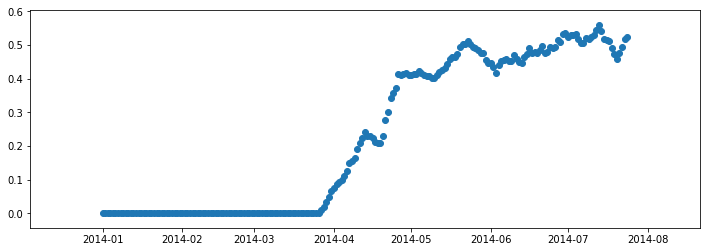

In [33]:
plt.figure(figsize=(12.0, 4.0))
plt.scatter(df_block_year.iloc[range(len(df_block_year) - window_size + 1)]['observation_date_dt'], means)
# plt.scatter(df_block_year.iloc[range(len(df_block_year) - window_size + 1)]['observation_date_dt'], upper_bounds)
plt.show()

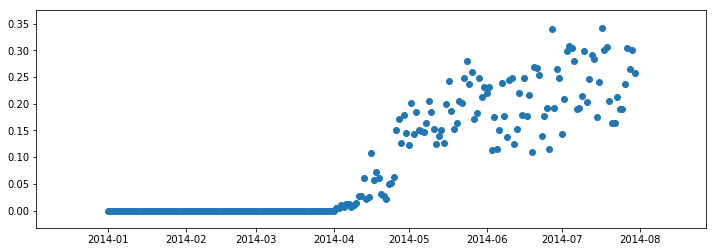

In [34]:
plt.figure(figsize=(12.0, 4.0))
plt.scatter(df_block_year['observation_date_dt'], df_block_year['prop'])
plt.show()

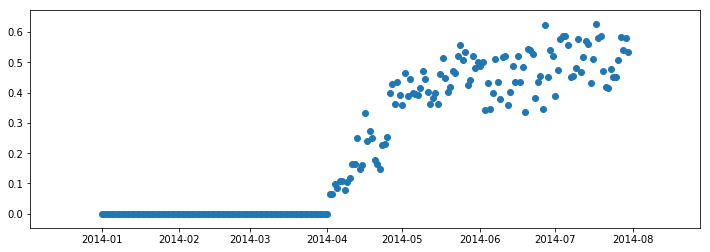

In [35]:
plt.figure(figsize=(12.0, 4.0))
plt.scatter(df_block_year['observation_date_dt'], df_block_year['prop_arcsine'])
plt.show()

In [36]:
# Logistic growth function approach

In [37]:
def logistic_function(t, a, b, c):
    return c/(1 + a*np.exp(-b*t))

In [38]:
df_block_year_logistic = df_block_year.reset_index()

In [39]:
df_block_year_logistic.rename(columns={'index': 't'}, inplace=True)

In [40]:
df_block_year_logistic['t'] = df_block_year_logistic['t'] + 1

In [41]:
df_block_year_logistic.head(2)

,t,grid_cell,year,observation_date,observation_date_dt,nb_checklists,nb_checklists_species,prop,prop_arcsine
0,1,136,2014,2014-01-01,2014-01-01,501,0.0,0.0,0.0
1,2,136,2014,2014-01-02,2014-01-02,162,0.0,0.0,0.0


In [42]:
p0 = []
for i in range(3):
    p0.append(random.uniform(0, 1))
print(p0)

[0.9274453684758169, 0.5720439290907612, 0.8535482015835305]


In [43]:
bounds = (0, [100000, 100, 1])

In [44]:
x = df_block_year_logistic['t']
y = df_block_year_logistic['prop']

In [45]:
# Nonlinear least squares optimization
popt, pcov = optim.curve_fit(logistic_function, x, y, bounds=bounds, p0=p0)

In [46]:
a_optim, b_optim, c_optim = popt
print(a_optim, b_optim, c_optim)
# 217.64014510384544 0.1438554152218848 0.20068378491939712

99999.99999992017 0.09705093024968776 0.22445799119663873


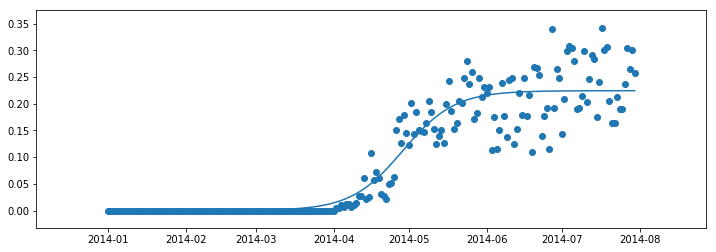

In [47]:
plt.figure(figsize=(12.0, 4.0))
plt.scatter(df_block_year_logistic['observation_date_dt'], y)
plt.plot(df_block_year_logistic['observation_date_dt'], logistic_function(x, a_optim, b_optim, c_optim))
plt.show()

In [49]:
df_block_year_logistic.head(2)

,t,grid_cell,year,observation_date,observation_date_dt,nb_checklists,nb_checklists_species,prop,prop_arcsine
0,1,136,2014,2014-01-01,2014-01-01,501,0.0,0.0,0.0
1,2,136,2014,2014-01-02,2014-01-02,162,0.0,0.0,0.0


In [51]:
import matplotlib as mpl

In [54]:
mpl.rcParams['font.size'] = 12

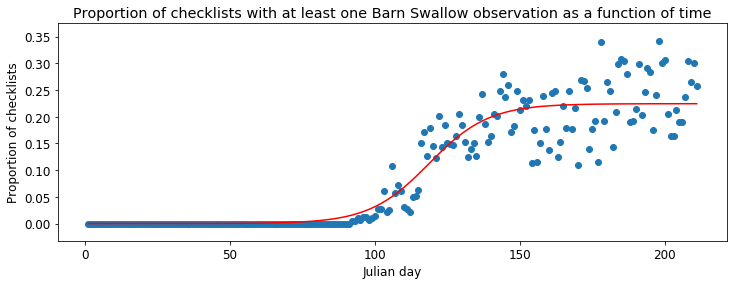

In [56]:
plt.figure(figsize=(12.0, 4.0))
plt.scatter(df_block_year_logistic['t'], y)
plt.plot(df_block_year_logistic['t'], logistic_function(x, a_optim, b_optim, c_optim), c='red')
plt.xlabel('Julian day')
plt.ylabel('Proportion of checklists')
plt.title('Proportion of checklists with at least one Barn Swallow observation as a function of time')
plt.show()

In [ ]:
# Time step for mean arrival date
mad = np.log(a_optim) / b_optim
print(mad)
# 118.62766764840377

In [ ]:
# Time step for mean arrival date, rounded down
print(math.floor(mad))
# 118
# Time step for mean arrival date, rounded up
print(math.ceil(mad))
# 119

In [ ]:
# Mean arrival date, rounded down
print(df_block_year_logistic[df_block_year_logistic['t'] == math.floor(mad)]['observation_date'])
# 2014-04-25
# 2014-04-28
# Mean arrival date, rounded up
print(df_block_year_logistic[df_block_year_logistic['t'] == math.ceil(mad)]['observation_date'])
# 2014-04-26
# 2014-04-29

In [ ]:
lower_bound_c = (2.5 / 100) * c_optim
print(lower_bound_c)

upper_bound_c = (97.5 / 100) * c_optim
print(upper_bound_c)

In [ ]:
lower_bound_t = -np.log((1 / a_optim)*(c_optim / lower_bound_c - 1)) / b_optim
print(lower_bound_t)

upper_bound_t = -np.log((1 / a_optim)*(c_optim / upper_bound_c - 1)) / b_optim
print(upper_bound_t)

print(upper_bound_t - lower_bound_t)

In [ ]:
lower_bound_date = df_block_year_logistic[df_block_year_logistic['prop'] >= 
                                          lower_bound_c]['observation_date_dt'].min()
print(lower_bound_date)

upper_bound_date = df_block_year_logistic[df_block_year_logistic['prop'] <= 
                                          upper_bound_c]['observation_date_dt'].max()
print(upper_bound_date)

In [ ]:
residuals = y - logistic_function(x, a_optim, b_optim, c_optim)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
# R-squared
print(r_squared)